In [1]:
import os
import os.path as osp
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from dataset import pairDataset

In [2]:
img_pairs = []
labels = []
with open('./dataset/positive_pair.txt') as f:
    for line in f.readlines():
        line = line.strip()
        img_pairs.append((line.split(',')[0], line.split(',')[1]))
        labels.append(1)
with open('./dataset/negative_pair.txt') as f:
    for line in f.readlines():
        line = line.strip()
        img_pairs.append((line.split(',')[0], line.split(',')[1]))
        labels.append(0)
test_ratio = 0.05
train_img_pairs, test_img_pairs, train_labels, test_labels = train_test_split(img_pairs,
                                                                              labels,
                                                                              test_size=test_ratio,
                                                                              random_state=42)
train_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
)
train_dataset = pairDataset(train_img_pairs, train_labels, train_transform)
test_dataset = pairDataset(test_img_pairs, test_labels, test_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=6)

In [3]:
# 将tuple的两项用,连接成一个字符串
train_img_pairs = [','.join(i) for i in train_img_pairs]
test_img_pairs = [','.join(i) for i in test_img_pairs]

In [4]:
train_dict = {img: label for (img, label) in zip(train_img_pairs, train_labels)}
test_dict = {img: label for (img, label) in zip(test_img_pairs, test_labels)}

In [ ]:
# import random
#
# test_list1 = [] # test image path
# test_list2 = [] # train image path
# label_list = []
# for i in test_dict:
#     # random select 0.002 ratio of train dict
#     random_train_dict = dict(random.sample(train_dict.items(), int(len(train_dict) * 0.002)))
#     for j in random_train_dict:
#         test_list1.append(i)
#         test_list2.append(j)
#         if test_dict[i] == train_dict[j]:
#             label_list.append(1)
#         else:
#             label_list.append(0)

In [15]:
# # 保存到文件
# with open('dataset/pair_pair.txt', 'w') as f:
#     for i in range(len(test_list1)):
#         f.write(test_list1[i] + ' ' + test_list2[i] + ' ' + str(label_list[i]) + '\n')

In [14]:
import random

test_list1 = [] # test image path
test_list2 = [] # train image path
label_list = []
for i in train_dict:
    # random select 0.0001 ratio of train dict
    random_train_dict = dict(random.sample(train_dict.items(), int(len(train_dict) * 0.0001)))
    for j in random_train_dict:
        test_list1.append(i)
        test_list2.append(j)
        if train_dict[i] == train_dict[j]:
            label_list.append(1)
        else:
            label_list.append(0)

# 保存到文件
with open('dataset/train_pair_pair.txt', 'w') as f:
    for i in range(len(test_list1)):
        f.write(test_list1[i] + ' ' + test_list2[i] + ' ' + str(label_list[i]) + '\n')

In [5]:
from torchvision.models import resnet50

device = torch.device('mps')
model = resnet50()
model.fc = nn.Flatten()
# model = model.to(torch.device('cpu'))
model.load_state_dict(torch.load('./model/20230702-231206-densenet_model39.pt', map_location=torch.device('cpu')), strict=True)
model = model.to(device)
model.eval()
# # assert all model parameters are in the device, if not, print the parameters key
# for key in model.state_dict():
#     if not model.state_dict()[key].device == device:
#         print(key, model.state_dict()[key].device, device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
# train_features = torch.zeros(len(train_loader.dataset), 2048, dtype=torch.float)
# test_features = torch.zeros(len(test_loader.dataset), 2048, dtype=torch.float)
# with torch.no_grad():
#     for i, (X1, X2, y) in enumerate(train_loader):
#         print(i, len(train_loader), end='\r')
#         X1, X2 = X1.to(device), X2.to(device)
#         features1 = model(X1)
#         features2 = model(X2)
#         train_features[i * 32: i * 32 + 32, :] = (features1 + features2).cpu()
#         torch.cuda.empty_cache()
#     for i, (X1, X2, y) in enumerate(test_loader):
#         print(i, len(test_loader), end='\r')
#         X1, X2 = X1.to(device), X2.to(device)
#         features1 = model(X1)
#         features2 = model(X2)
#         test_features[i * 32: i * 32 + 32, :] = (features1 + features2).cpu()
#         torch.cuda.empty_cache()

In [7]:
# train_features = train_features.cpu().detach().numpy()
# test_features = test_features.cpu().detach().numpy()

In [8]:
# # save to file
# np.save('train_features.npy', train_features)
# np.save('test_features.npy', test_features)

In [7]:
# load from file
train_features = np.load('train_features.npy')
test_features = np.load('test_features.npy')

In [8]:
results_2 = {img: feature for (img, feature) in zip(train_img_pairs, train_features)}
results_1 = {img: feature for (img, feature) in zip(test_img_pairs, test_features)}
# 合并两个字典
results = {**results_1, **results_2}  # (img_path_pair, pair_feature)

In [9]:
def cosin_metric(x1, x2):
    return np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))

## 按配对进行测试

In [10]:
def threshold_search(y_score, y_true):
    y_score = np.asarray(y_score)
    y_true = np.asarray(y_true)
    best_acc = 0
    best_th = 0
    for i in range(len(y_score)):
        if i % 1000 == 0:
            print(i, '\t', len(y_score))
        th = y_score[i]
        y_test = (y_score >= th)
        acc = np.mean((y_test == y_true).astype(int))
        if acc > best_acc:
            best_acc = acc
            best_th = th
    return best_acc, best_th

In [11]:
def compute_accuracy(feature_dict, pair_list):
    with open(pair_list, 'r') as f:
        pairs = f.readlines()

    similarities = []
    labels = []
    for i, pair in enumerate(pairs):
        if i % 1000 == 0:
            print(i, '\t', len(pairs))
        img1, img2, label = pair.split()
        feature1 = feature_dict[img1]
        feature2 = feature_dict[img2]
        label = int(label)

        similarity = cosin_metric(feature1, feature2)
        similarities.append(similarity)
        labels.append(label)

    accuracy, threshold = threshold_search(similarities, labels)
    return accuracy, threshold, similarities, labels

In [33]:
acc, thresh, sim, labels = compute_accuracy(results, 'dataset/pair_pair.txt')
print('accuracy: {:.4f}, threshold: {:.4f}'.format(acc, thresh))

0 	 277644
1000 	 277644
2000 	 277644
3000 	 277644
4000 	 277644
5000 	 277644
6000 	 277644
7000 	 277644
8000 	 277644
9000 	 277644
10000 	 277644
11000 	 277644
12000 	 277644
13000 	 277644
14000 	 277644
15000 	 277644
16000 	 277644
17000 	 277644
18000 	 277644
19000 	 277644
20000 	 277644
21000 	 277644
22000 	 277644
23000 	 277644
24000 	 277644
25000 	 277644
26000 	 277644
27000 	 277644
28000 	 277644
29000 	 277644
30000 	 277644
31000 	 277644
32000 	 277644
33000 	 277644
34000 	 277644
35000 	 277644
36000 	 277644
37000 	 277644
38000 	 277644
39000 	 277644
40000 	 277644
41000 	 277644
42000 	 277644
43000 	 277644
44000 	 277644
45000 	 277644
46000 	 277644
47000 	 277644
48000 	 277644
49000 	 277644
50000 	 277644
51000 	 277644
52000 	 277644
53000 	 277644
54000 	 277644
55000 	 277644
56000 	 277644
57000 	 277644
58000 	 277644
59000 	 277644
60000 	 277644
61000 	 277644
62000 	 277644
63000 	 277644
64000 	 277644
65000 	 277644
66000 	 277644
67000 	 

In [34]:
# 输出labels为1的sim
sim1 = []
for i in range(len(sim)):
    if labels[i] == 1:
        sim1.append(sim[i])
# print('sim1: ', sim1)

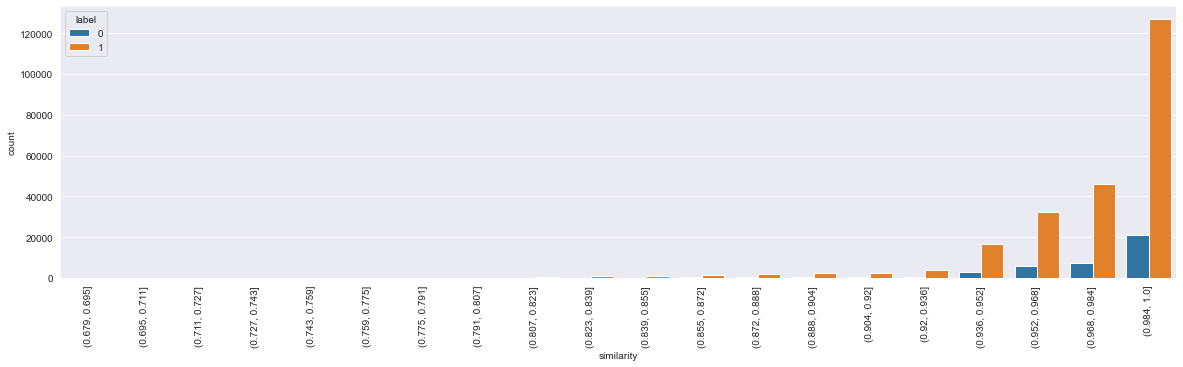

In [35]:
# 使用分箱绘制similarity分布图，不同labels用不同颜色表示
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.figure(figsize=(20, 5))
sim = np.array(sim)
labels = np.array(labels)
df = pd.DataFrame({'similarity': sim, 'label': labels})
df['similarity'] = pd.cut(df['similarity'], bins=10)
df = df.groupby(['similarity', 'label']).size().reset_index().rename(columns={0: 'count'})
sns.barplot(x='similarity', y='count', hue='label', data=df)
plt.xticks(rotation=90)
plt.show()

## 按最优匹配进行测试

In [39]:
acc = []
for id, i in enumerate(test_img_pairs):
    if id % 50 == 0:
        print(id, '\t', len(test_img_pairs))
    test_feature = results[i]
    sim = []
    for j in train_img_pairs:
        train_feature = results[j]
        sim.append(cosin_metric(test_feature, train_feature))
    max_score = max(sim)
    max_index = sim.index(max_score)
    if test_dict[i] == train_dict[train_img_pairs[max_index]]:
        acc.append(1)
    else:
        acc.append(0)
print('accuracy: {:.4f}'.format(sum(acc) / len(acc)))

0 	 2727
50 	 2727
100 	 2727
150 	 2727
200 	 2727
250 	 2727
300 	 2727
350 	 2727
400 	 2727
450 	 2727
500 	 2727
550 	 2727
600 	 2727
650 	 2727
700 	 2727
750 	 2727
800 	 2727
850 	 2727
900 	 2727
950 	 2727
1000 	 2727
1050 	 2727
1100 	 2727
1150 	 2727
1200 	 2727
1250 	 2727
1300 	 2727
1350 	 2727
1400 	 2727
1450 	 2727
1500 	 2727
1550 	 2727
1600 	 2727
1650 	 2727
1700 	 2727
1750 	 2727
1800 	 2727
1850 	 2727
1900 	 2727
1950 	 2727
2000 	 2727
2050 	 2727
2100 	 2727
2150 	 2727
2200 	 2727
2250 	 2727
2300 	 2727
2350 	 2727
2400 	 2727
2450 	 2727
2500 	 2727
2550 	 2727
2600 	 2727
2650 	 2727
2700 	 2727
accuracy: 0.8654


## 训练集

In [15]:
acc, thresh, sim, labels = compute_accuracy(results, 'dataset/train_pair_pair.txt')
print('accuracy: {:.4f}, threshold: {:.4f}'.format(acc, thresh))

0 	 257085
1000 	 257085
2000 	 257085
3000 	 257085
4000 	 257085
5000 	 257085
6000 	 257085
7000 	 257085
8000 	 257085
9000 	 257085
10000 	 257085
11000 	 257085
12000 	 257085
13000 	 257085
14000 	 257085
15000 	 257085
16000 	 257085
17000 	 257085
18000 	 257085
19000 	 257085
20000 	 257085
21000 	 257085
22000 	 257085
23000 	 257085
24000 	 257085
25000 	 257085
26000 	 257085
27000 	 257085
28000 	 257085
29000 	 257085
30000 	 257085
31000 	 257085
32000 	 257085
33000 	 257085
34000 	 257085
35000 	 257085
36000 	 257085
37000 	 257085
38000 	 257085
39000 	 257085
40000 	 257085
41000 	 257085
42000 	 257085
43000 	 257085
44000 	 257085
45000 	 257085
46000 	 257085
47000 	 257085
48000 	 257085
49000 	 257085
50000 	 257085
51000 	 257085
52000 	 257085
53000 	 257085
54000 	 257085
55000 	 257085
56000 	 257085
57000 	 257085
58000 	 257085
59000 	 257085
60000 	 257085
61000 	 257085
62000 	 257085
63000 	 257085
64000 	 257085
65000 	 257085
66000 	 257085
67000 	 

In [16]:
# 输出labels为1的sim
sim1 = []
for i in range(len(sim)):
    if labels[i] == 1:
        sim1.append(sim[i])
# print('sim1: ', sim1)

accuracy: 0.8498, threshold: 0.6740


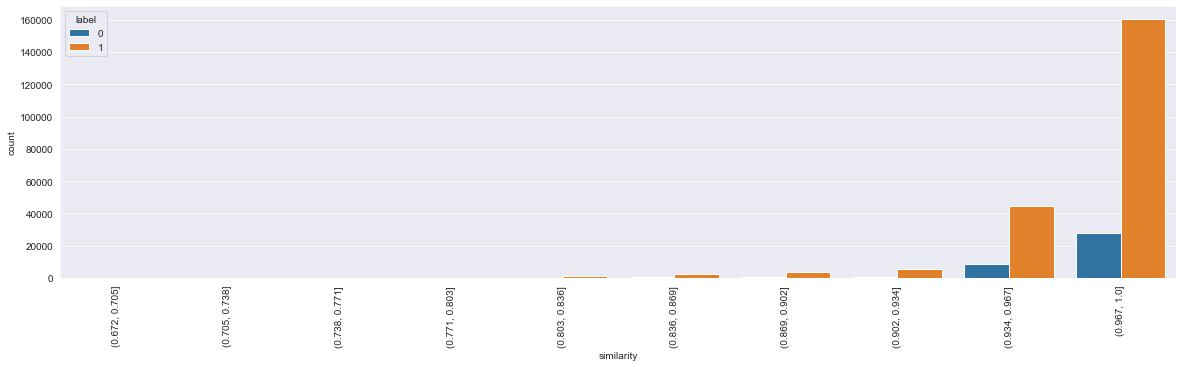

In [17]:
# 使用分箱绘制similarity分布图，不同labels用不同颜色表示
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.figure(figsize=(20, 5))
sim = np.array(sim)
labels = np.array(labels)
df = pd.DataFrame({'similarity': sim, 'label': labels})
df['similarity'] = pd.cut(df['similarity'], bins=10)
df = df.groupby(['similarity', 'label']).size().reset_index().rename(columns={0: 'count'})
sns.barplot(x='similarity', y='count', hue='label', data=df)
plt.xticks(rotation=90)
plt.show()